In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Dataset preparation

In [ ]:
#copy pneumonia dataset and unzip

!cp '/content/drive/Shareddrives/fyp/dataset/paultimothy/archive.zip' .

# unzip
!unzip -q 'archive.zip'

In [ ]:
#copy covid dataset 
!cp '/content/drive/Shareddrives/fyp/dataset/tawsifurrahman covid/archive.zip' './covid.zip' 

# unzip
!unzip -q 'covid.zip'

In [ ]:
!mkdir pauldataset

In [ ]:
# copy pneumonia images to created folder
!cp -r '/content/chest_xray/test/PNEUMONIA/.' '/content/pauldataset/pneumonia/'
!cp -r '/content/chest_xray/train/PNEUMONIA/.' '/content/pauldataset/pneumonia/'
!cp -r '/content/chest_xray/val/PNEUMONIA/.' '/content/pauldataset/pneumonia/'

In [ ]:
!ls /content/pauldataset/pneumonia/ | wc -l

4273


In [ ]:
# copy normal images to created folder
!cp -r '/content/chest_xray/test/NORMAL/.' '/content/pauldataset/normal/'
!cp -r '/content/chest_xray/train/NORMAL/.' '/content/pauldataset/normal/'
!cp -r '/content/chest_xray/val/NORMAL/.' '/content/pauldataset/normal/'

In [ ]:
!ls /content/pauldataset/normal/ | wc -l

1583


In [ ]:
# copy covid images to created folder
!cp -r '/content/COVID-19_Radiography_Dataset/COVID/.' '/content/pauldataset/covid/'

In [ ]:
!ls /content/pauldataset/covid/ | wc -l

3616


# Import libraries

In [ ]:
import os
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from random import shuffle
import random

In [ ]:
import tensorflow as tf
import tensorflow.keras.layers as tfl
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from tensorflow.keras.layers.experimental.preprocessing import RandomFlip

# Define constants & methods

In [ ]:
from requests import get
version_name = get('http://172.28.0.2:9000/api/sessions').json()[0]['name'].split('.')[0]
save_model_path = "/content/drive/Shareddrives/fyp/models/mobileNet/Hash/"+version_name+".h5"
save_history_path = "/content/drive/Shareddrives/fyp/models/mobileNet/Hash/"+version_name

In [ ]:
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)

input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT, 3)

In [ ]:
# plot graphs for training and valdation data
def plot_graphs(history):
  acc = [0.] + history.history['accuracy']
  val_acc = [0.] + history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(acc,'o-g', label='Training Accuracy')
  plt.plot(val_acc, 'o-r',label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.ylabel('Accuracy')
  plt.ylim([min(plt.ylim()),1])
  plt.title('Training and Validation Accuracy')

  plt.subplot(2, 1, 2)
  plt.plot(loss, 'o-g', label='Training Loss')
  plt.plot(val_loss, 'o-r',label='Validation Loss',color='red')
  plt.legend(loc='upper right')
  plt.ylabel('Cross Entropy')
  plt.ylim([0,3.0])
  plt.title('Training and Validation Loss')
  plt.xlabel('epoch')
  plt.show()

In [ ]:
# get accuray of test data
def getModelAccuracy(dataframe):
    sample_test = dataframe
    correctPredictions = 0

    correctNormalPred = 0
    correctCovidPred = 0
    correctPneumoniaPred = 0

    totalNormalPred = 0
    totalCovidPred = 0
    totalPneumoniaPred = 0

    for index, row in sample_test.iterrows():

        filename = row['filename']
        prediction = row['category']

        # img = load_img(path + 'CrossValidationDataset\\' + filename, target_size=IMAGE_SIZE)

        if (path +'/normal') in filename:

            if prediction == 0:
                correctPredictions += 1
                correctNormalPred += 1

            totalNormalPred += 1

        if (path + '/covid') in filename:

            if prediction == 1: 
                correctPredictions += 1
                correctCovidPred += 1

            totalCovidPred += 1

        if (path + '/pneumonia') in filename:

            if prediction == 2: 
                correctPredictions += 1
                correctPneumoniaPred += 1

            totalPneumoniaPred += 1
            
    print('Model Accuracy:', "{:.2%}".format(correctPredictions / test_df.shape[0]))
    print('Correct Predictions:', correctPredictions, 'Total Predictions:', test_df.shape[0])

    print('\nNormal Predictions:', correctNormalPred, 'Accuracy', "{:.2%}".format(correctNormalPred /  totalNormalPred))
    print('Covid Predictions:', correctCovidPred, 'Accuracy', "{:.2%}".format(correctCovidPred /  totalCovidPred))
    print('Pneumonia Predictions:', correctPneumoniaPred, 'Accuracy', "{:.2%}".format(correctPneumoniaPred / totalPneumoniaPred))
    
    return (correctPredictions / test_df.shape[0]) * 100

In [ ]:
# plot confusion matrix
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import itertools

# np_config.enable_numpy_behavior()
    
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion Matrix',
                          cmap=None,
                          normalize=True):

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Oranges')

    plt.figure(figsize=(5, 4))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    # thresh = np.max(cm) / 1.5 if normalize else np.max(cm) / 2

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    



In [ ]:
path = "/content/pauldataset"

# Model






In [ ]:
def CNNModel():
  init_model = tf.keras.applications.mobilenet_v2.MobileNetV2(include_top=False, input_shape=input_shape)
  x = init_model.output
  x = tfl.GlobalAveragePooling2D()(x)
  x = tfl.Dropout(0.2)(x)
  x = tfl.Dense(3, activation='softmax')(x) # 3 units
  new_model = Model(inputs=init_model.input, outputs=x)
  # without freezing layers - without getting pre-trained parameters

  return new_model

In [ ]:
test_model = CNNModel()

9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
test_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

# Create dataframe

In [ ]:
directories = ['/normal']
categories = []
filenames = []
    
files = os.listdir(path + directories[0])

for img in files:
    categories.append(0)
    filenames.append(path+directories[0]+"/"+img)

files.sort()
df_NORMAL = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

print(df_NORMAL.shape[0])
df_NORMAL.head()

directories = ['/pneumonia']
categories = []
filenames = []
    
files = os.listdir(path + directories[0])

for img in files:
    categories.append(2)
    filenames.append(path+directories[0]+"/"+img)

files.sort()
df_PNEUMONIA = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

print(df_PNEUMONIA.shape[0])
df_PNEUMONIA.head()

directories = ['/covid']
categories = []
filenames = []
    
files = os.listdir(path + directories[0])

for img in files:
    categories.append(1)
    filenames.append(path+directories[0]+"/"+img)

files.sort()
df_COVID = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

print(df_COVID.shape[0])
df_COVID.head()


1583
4273
3616


,filename,category
0,/content/pauldataset/covid/COVID-3084.png,1
1,/content/pauldataset/covid/COVID-2997.png,1
2,/content/pauldataset/covid/COVID-2805.png,1
3,/content/pauldataset/covid/COVID-2145.png,1
4,/content/pauldataset/covid/COVID-414.png,1


In [ ]:
pd.options.display.max_colwidth = 100

In [ ]:
df_NORMAL, df_NORMAL_evaluation = train_test_split(df_NORMAL, test_size=0.40)
df_PNEUMONIA, df_PNEUMONIA_evaluation = train_test_split(df_PNEUMONIA, test_size=0.40)
df_COVID, df_COVID_evaluation = train_test_split(df_COVID, test_size=0.40)

df_NORMAL_test, df_NORMAL_val = train_test_split(df_NORMAL_evaluation, test_size=0.50)
df_PNEUMONIA_test, df_PNEUMONIA_val = train_test_split(df_PNEUMONIA_evaluation, test_size=0.50)
df_COVID_test, df_COVID_val = train_test_split(df_COVID_evaluation, test_size=0.50)

train_df = pd.concat([df_NORMAL, df_PNEUMONIA, df_COVID])
test_df = pd.concat([df_NORMAL_test, df_PNEUMONIA_test, df_COVID_test])
validation_df = pd.concat([df_NORMAL_val, df_PNEUMONIA_val, df_COVID_val])

In [ ]:
train_df["category"].value_counts()

2    2563
1    2169
0     949
Name: category, dtype: int64

In [ ]:
test_df["category"].value_counts()

2    855
1    723
0    317
Name: category, dtype: int64

In [ ]:
validation_df["category"].value_counts()

2    855
1    724
0    317
Name: category, dtype: int64

In [ ]:
# shuffle data
train_df = train_df.sample(frac=1).reset_index(drop = True)
test_df = test_df.sample(frac=1).reset_index(drop = True)
validation_df = validation_df.sample(frac=1).reset_index(drop = True)
train_df

,filename,category
0,/content/pauldataset/normal/NORMAL2-IM-1266-0001-0002.jpeg,0
1,/content/pauldataset/normal/NORMAL2-IM-0478-0001.jpeg,0
2,/content/pauldataset/pneumonia/person749_bacteria_2652.jpeg,2
3,/content/pauldataset/covid/COVID-3500.png,1
4,/content/pauldataset/covid/COVID-1507.png,1
...,...,...
5676,/content/pauldataset/covid/COVID-2766.png,1
5677,/content/pauldataset/covid/COVID-89.png,1
5678,/content/pauldataset/covid/COVID-861.png,1
5679,/content/pauldataset/covid/COVID-348.png,1


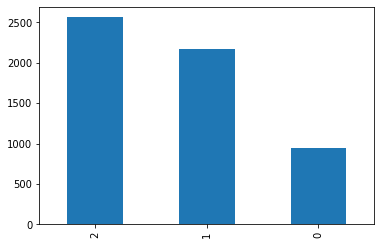

In [ ]:
train_df['category'].value_counts().plot.bar()

train/val/test split - 60% | 20% | 20%

In [ ]:
batch_size = 32
train_df["category"] = train_df["category"].replace({0: 'Normal', 1: 'Covid', 2:'Pneumonia'})
test_df["category"] = test_df["category"].replace({0: 'Normal', 1: 'Covid', 2:'Pneumonia'})
validation_df["category"] = validation_df["category"].replace({0: 'Normal', 1: 'Covid', 2:'Pneumonia'})

test_generator_eval = ImageDataGenerator(rescale=1./255).flow_from_dataframe (
        test_df, 
        x_col = 'filename',
        y_col = 'category',
        target_size = IMAGE_SIZE,
        class_mode = 'categorical',
        batch_size = batch_size,
        shuffle = False
    )

train_generator = ImageDataGenerator(
    rescale=1./255,
    width_shift_range = 0.1,
    height_shift_range = 0.1
    ).flow_from_dataframe (
        train_df, 
        x_col = 'filename',
        y_col = 'category',
        target_size = IMAGE_SIZE,
        class_mode = 'categorical',
        batch_size = batch_size,
        seed = 123
    )

val_generator = ImageDataGenerator(rescale=1./255).flow_from_dataframe (
        validation_df, 
        x_col = 'filename',
        y_col = 'category',
        target_size = IMAGE_SIZE,
        class_mode = 'categorical',
        batch_size = batch_size,
        seed = 123
    )

Found 1895 validated image filenames belonging to 3 classes.
Found 5681 validated image filenames belonging to 3 classes.
Found 1896 validated image filenames belonging to 3 classes.


(32, 224, 224, 3)


/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


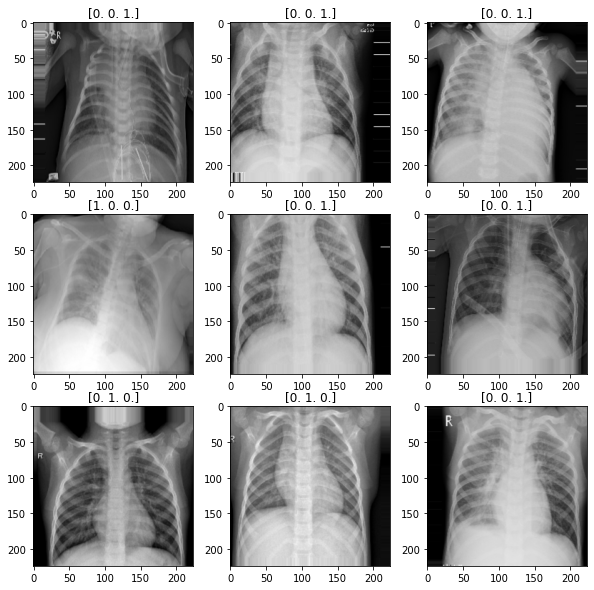

In [ ]:
plt.figure(figsize=(10, 10))
batch=next(train_generator)  # returns the next batch of images and labels 
print(batch[0].shape) # batch[0] is the images, batch[1] are the labels

for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  img=batch[0][i]
  plt.title(batch[1][i])
  plt.imshow(img)  

# Model

In [ ]:
model = CNNModel()

model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate= 0.0001),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
#               loss=tf.keras.losses.CategoricalCrossentropy(),
#               metrics=['accuracy'])

In [ ]:
# early_stopping = EarlyStopping(patience=10, verbose=1)
model_checkpoint = ModelCheckpoint(save_model_path, save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1)

In [ ]:
epochs = 40
history = model.fit(train_generator,
                    validation_data=val_generator, 
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[model_checkpoint, reduce_lr])

Epoch 1/40
178/178 [==============================] - 181s 799ms/step - loss: 0.1557 - accuracy: 0.9449 - val_loss: 0.5449 - val_accuracy: 0.8133

Epoch 00001: val_loss improved from inf to 0.54487, saving model to /content/drive/Shareddrives/fyp/models/mobileNet/Hash/MobileNetV2_dasa_(V9).h5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/40
178/178 [==============================] - 141s 792ms/step - loss: 0.0701 - accuracy: 0.9773 - val_loss: 0.5571 - val_accuracy: 0.8085

Epoch 00002: val_loss did not improve from 0.54487
Epoch 3/40
178/178 [==============================] - 139s 780ms/step - loss: 0.0579 - accuracy: 0.9812 - val_loss: 0.7546 - val_accuracy: 0.8312

Epoch 00003: val_loss did not improve from 0.54487
Epoch 4/40
178/178 [==============================] - 141s 792ms/step - loss: 0.0492 - accuracy: 0.9835 - val_loss: 1.3837 - val_accuracy: 0.7621

Epoch 00004: val_loss did not improve from 0.54487
Epoch 5/40
178/178 [==============================] - 142s 794ms/step - loss: 0.0394 - accuracy: 0.9859 - val_loss: 0.6787 - val_accuracy: 0.8423

Epoch 00005: val_loss did not improve from 0.54487
Epoch 6/40
178/178 [==============================] - 142s 795ms/step - loss: 0.0365 - accuracy: 0.9864 - val_loss: 0.9593 - val_accuracy: 0.8444

Epoch 00006: val_loss did not improve from 0.54487

Epoch 000

In [ ]:
model.save(save_model_path)

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


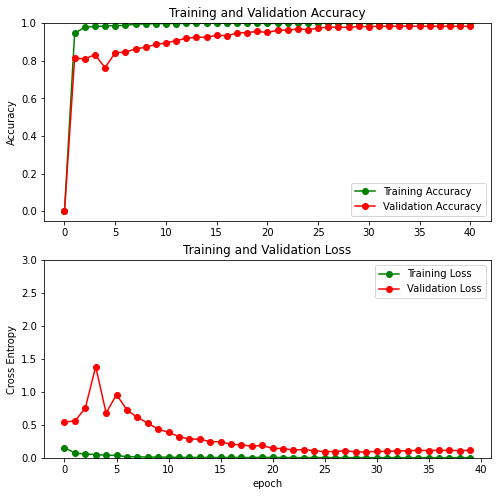

In [ ]:
plot_graphs(history)

In [ ]:
model.evaluate(test_generator_eval)

60/60 [==============================] - 17s 278ms/step - loss: 0.0504 - accuracy: 0.9889


[0.05039963126182556, 0.9889181852340698]

In [ ]:
filename = save_history_path+"history1.npy"
np.save(filename,history.history)

In [ ]:
history1=np.load(filename,allow_pickle='TRUE').item()

Found 1895 validated image filenames.
Model Accuracy: 98.89%
Correct Predictions: 1874 Total Predictions: 1895

Normal Predictions: 308 Accuracy 97.16%
Covid Predictions: 723 Accuracy 100.00%
Pneumonia Predictions: 843 Accuracy 98.60%


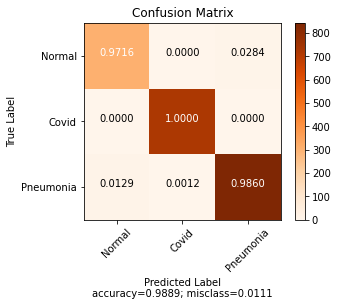

              precision    recall  f1-score   support

      Normal       0.97      0.97      0.97       317
       Covid       1.00      1.00      1.00       723
   Pneumonia       0.99      0.99      0.99       855

    accuracy                           0.99      1895
   macro avg       0.98      0.99      0.99      1895
weighted avg       0.99      0.99      0.99      1895



In [ ]:
##Testing model 
nb_samples = test_df.shape[0]

test_generator = ImageDataGenerator(rescale = 1./255).flow_from_dataframe(
    test_df, 
    x_col = 'filename',
    y_col = None,
    class_mode = None,
    target_size = IMAGE_SIZE,
    batch_size = batch_size,
    shuffle = False
)

#Get Test Data Predictions 
predict = model.predict(test_generator, steps=np.ceil(nb_samples/batch_size))


test_df['category'] = np.argmax(predict, axis=-1)
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)
test_df['category'] = test_df['category'].replace({'Normal': 0, 'Covid': 1, 'Pneumonia': 2})

actual = []
pred = []

for row in test_df.iterrows():

    filename = row[1][0]

    if (path + '/normal') in filename: actual.append(0)
    if (path + '/covid') in filename: actual.append(1)
    if (path + '/pneumonia') in filename: actual.append(2)
    pred.append(row[1][1])


# Get performance metrics  
accuracy = getModelAccuracy(test_df)

cf = confusion_matrix(actual, pred)  
target_names = ['Normal','Covid', 'Pneumonia']
plot_confusion_matrix(cf, target_names)

print(classification_report(actual, pred, target_names=target_names))  

In [ ]:
actual

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np


cm = cf
recall = np.diag(cm) / np.sum(cm, axis = 1)
precision = np.diag(cm) / np.sum(cm, axis = 0)

In [ ]:
np.mean(recall)

0.9858579150294243

In [ ]:
np.mean(precision)

0.9845242152093356

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

# calculate precision
precision = precision_score(actual, pred,  average='macro')
print('Precision:', precision)

# calculate recall
recall = recall_score(actual, pred,  average='macro')
print('Recall:', recall)

# f1
# f1 =  2 * (precision * recall) / (precision + recall)
f1 = f1_score(actual, pred,  average='macro')
print ("F1 :", f1)

print(confusion_matrix(actual, pred))

Precision: 0.9845242152093356
Recall: 0.9858579150294243
F1 : 0.9851866964686747
[[308   0   9]
 [  0 723   0]
 [ 11   1 843]]


In [ ]:
print(accuracy) #rms

98.89182058047493


# Saved model

In [ ]:
loaded_model = tf.keras.models.load_model(save_model_path)











































































































# predict

Found 1895 validated image filenames.
Model Accuracy: 98.89%
Correct Predictions: 1874 Total Predictions: 1895

Normal Predictions: 308 Accuracy 97.16%
Covid Predictions: 723 Accuracy 100.00%
Pneumonia Predictions: 843 Accuracy 98.60%


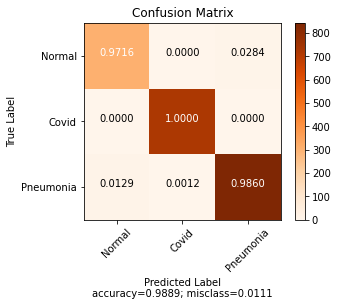

              precision    recall  f1-score   support

      Normal       0.97      0.97      0.97       317
       Covid       1.00      1.00      1.00       723
   Pneumonia       0.99      0.99      0.99       855

    accuracy                           0.99      1895
   macro avg       0.98      0.99      0.99      1895
weighted avg       0.99      0.99      0.99      1895



In [ ]:
##Testing model 
nb_samples = test_df.shape[0]

test_generator = ImageDataGenerator(rescale = 1./255).flow_from_dataframe(
    test_df, 
    x_col = 'filename',
    y_col = None,
    class_mode = None,
    target_size = IMAGE_SIZE,
    batch_size = batch_size,
    shuffle = False
)

#Get Test Data Predictions 
predict = loaded_model.predict(test_generator, steps=np.ceil(nb_samples/batch_size))


test_df['category'] = np.argmax(predict, axis=-1)
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)
test_df['category'] = test_df['category'].replace({'Normal': 0, 'Covid': 1, 'Pneumonia': 2})

actual = []
pred = []

for row in test_df.iterrows():

    filename = row[1][0]

    if (path + '/normal') in filename: actual.append(0)
    if (path + '/covid') in filename: actual.append(1)
    if (path + '/pneumonia') in filename: actual.append(2)
    pred.append(row[1][1])


# Get performance metrics  
accuracy = getModelAccuracy(test_df)

cf = confusion_matrix(actual, pred)  
target_names = ['Normal','Covid', 'Pneumonia']
plot_confusion_matrix(cf, target_names)

print(classification_report(actual, pred, target_names=target_names))  

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

# calculate precision
precision = precision_score(actual, pred,  average='macro')
print('Precision:', precision)

# calculate recall
recall = recall_score(actual, pred,  average='macro')
print('Recall:', recall)

# f1
# f1 =  2 * (precision * recall) / (precision + recall)
f1 = f1_score(actual, pred,  average='macro')
print ("F1 :", f1)

print(confusion_matrix(actual, pred))

Precision: 0.9845242152093356
Recall: 0.9858579150294243
F1 : 0.9851866964686747
[[308   0   9]
 [  0 723   0]
 [ 11   1 843]]


# Predict single

In [ ]:
batch_size = 1
nb_samples = 1

In [ ]:
test_file = ["/content/pauldataset/normal/NORMAL2-IM-1203-0001.jpeg"]
df_file = pd.DataFrame({
    'filename': test_file
})

In [ ]:
df_file

,filename
0,/content/pauldataset/normal/NORMAL2-IM-1203-0001.jpeg


In [ ]:
test_single_gen = ImageDataGenerator(rescale = 1./255).flow_from_dataframe(
    df_file, 
    x_col = 'filename',
    y_col = None,
    class_mode = None,
    target_size = IMAGE_SIZE,
    batch_size = batch_size,
    shuffle = False
)

Found 1 validated image filenames.


In [ ]:
predict = loaded_model.predict(test_single_gen, steps = np.ceil(nb_samples/batch_size))

In [ ]:
df_file['category'] = np.argmax(predict, axis=-1)

In [ ]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
df_file['category'] = df_file['category'].replace(label_map)

In [ ]:
df_file

,filename,category
0,/content/pauldataset/normal/NORMAL2-IM-1203-0001.jpeg,Normal
